# 1. Importing Libraries

In [1]:
import pandas as pd
import os
import pickle

# 2. Loading The Dataset & Define Paths For Files

In [2]:
df = pd.read_csv("/content/netflix_mood_recommender_test.csv")

In [45]:
TFIDF_MATRIX_PATH = 'tfidf_matrix.pkl'
VECTORIZER_PATH = 'tfidf_vectorizer.pkl'
CLUSTER_PATH = 'content_model.pkl'

#3. Process Features

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

if os.path.exists(VECTORIZER_PATH) and os.path.exists(TFIDF_MATRIX_PATH):
    with open(VECTORIZER_PATH, 'rb') as f:
        tfidf = pickle.load(f)
    with open(TFIDF_MATRIX_PATH, 'rb') as f:
        tfidf_matrix = pickle.load(f)
else:
    df['combined_text'] = df['mood'] + " " + df['description']
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['combined_text'])

    with open(VECTORIZER_PATH, 'wb') as f:
        pickle.dump(tfidf, f)
    with open(TFIDF_MATRIX_PATH, 'wb') as f:
        pickle.dump(tfidf_matrix, f)

# 4. Model Creation

In [33]:
from sklearn.cluster import KMeans

Implementing Elbow Method

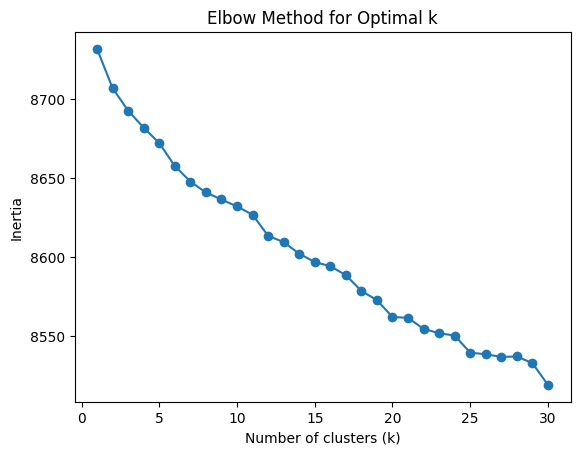

In [17]:
import matplotlib.pyplot as plt

# Range of cluster numbers to try
k_range = range(1, 31)

# List to store the inertia for each k
inertia = []

# Calculate inertia for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the inertia for each k
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [18]:
import numpy as np

# Calculate the differences in inertia
inertia_diff = np.diff(inertia)

# Find the index where the largest difference occurs
elbow_point = np.argmax(inertia_diff) + 1  # Add 1 because diff reduces the size by 1

print(f"The optimal number of clusters is approximately: {elbow_point}")

The optimal number of clusters is approximately: 27


In [34]:
if os.path.exists(CLUSTER_PATH):
    with open(CLUSTER_PATH, 'rb') as f:
        kmeans = pickle.load(f)
else:
    n_clusters = 27  # Based On Elbow Method
    kmeans = KMeans(n_clusters = n_clusters,
                    random_state = 42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    with open(CLUSTER_PATH, 'wb') as f:
        pickle.dump(kmeans, f)

# Assigning cluster labels to the DataFrame
df['cluster'] = cluster_labels

# 5. Function to Recommend Shows

In [46]:
import pickle
from sklearn.metrics.pairwise import cosine_similarity

def recommend_show(movie_title, num_recommendations, df = df, kmeans = kmeans, tfidf_matrix = tfidf_matrix, sim_matrix_path = 'cosine_similarity.pkl'):
    movie_id = df[df['title'] == movie_title].index[0]

    selected_cluster = df.loc[movie_id, 'cluster']

    # Filter movies in the same cluster
    cluster_movies = df[df['cluster'] == selected_cluster]

    cluster_tfidf = tfidf_matrix[cluster_movies.index]
    cosine_sim = cosine_similarity(cluster_tfidf)

    movie_index_in_cluster = cluster_movies.index.get_loc(movie_id)
    similar_movies = cluster_movies.iloc[cosine_sim[movie_index_in_cluster].argsort()[::-1][1:]]
    top_recommendations = similar_movies.head(num_recommendations)

    return top_recommendations['title'].tolist()

# Testing

In [47]:
title_to_search = "Friends"
num_recommendations = 10

recommended_shows = recommend_show(title_to_search, num_recommendations = num_recommendations)
print(f"Top {num_recommendations} recommended shows for '{title_to_search}':")
for show in recommended_shows:
    print(f"- {show}")

Top 10 recommended shows for 'Friends':
- Manhattan Romance
- O-Negative, Love Canât Be Designed
- Mehandi Circus
- Patron Mutlu Son Istiyor
- Workin' Moms
- Karthik Calling Karthik
- Omar & Salma 2
- Satrangi Re
- Ram Jaane
- Exes Baggage


Top 10 recommended shows for 'Friends':
- Manhattan Romance
- O-Negative, Love Canât Be Designed
- Mehandi Circus
- Patron Mutlu Son Istiyor
- Workin' Moms
- Karthik Calling Karthik
- Omar & Salma 2
- Satrangi Re
- Ram Jaane
- Exes Baggage

In [48]:
title_to_search = "Hitch"
num_recommendations = 10

recommended_shows = recommend_show(title_to_search, num_recommendations = num_recommendations)
print(f"Top {num_recommendations} recommended shows for '{title_to_search}':")
for show in recommended_shows:
    print(f"- {show}")

Top 10 recommended shows for 'Hitch':
- One Day
- Call My Agent!
- The Last Thing He Wanted
- Furthest Witness
- Upstarts
- Lethal Love
- Garuda Di Dadaku
- Alibaba Aur 40 Chor
- Ek Hasina Thi
- Operation Odessa


Top 10 recommended shows for 'Hitch':
- One Day
- Call My Agent!
- The Last Thing He Wanted
- Furthest Witness
- Upstarts
- Lethal Love
- Garuda Di Dadaku
- Alibaba Aur 40 Chor
- Ek Hasina Thi
- Operation Odessa

In [44]:
for mood in df['mood'].unique():
  count = df['mood'].value_counts().get(mood, 0)
  print(f"{mood}: {count}")

sadness, joy: 160
disgust, fear: 408
anger, disgust: 625
disgust, joy: 291
joy, fear: 143
fear, joy: 153
joy, anger: 133
disgust, sadness: 377
joy, surprise: 905
joy, disgust: 613
disgust, anger: 1360
fear, sadness: 364
surprise, joy: 217
fear, disgust: 569
anger, fear: 186
fear, surprise: 260
surprise, sadness: 34
sadness, disgust: 445
fear, anger: 435
anger, joy: 41
sadness, fear: 264
sadness, anger: 89
sadness, surprise: 72
joy, sadness: 301
anger, sadness: 61
surprise, anger: 42
surprise, fear: 110
disgust, surprise: 74
surprise, disgust: 61
anger, surprise: 16
